<center> <h1>Project Report: Predict The Heart Disease Diagnosis of Patients</h1> </center>

# Introduction

### Background
In today's medical community, although heart disease (HD) has become one of the more common diseases (Almustafa, 2020), it remains as one of the more important and severe diseases, potentially causing death and other serious consequences as soon as its onset (Baidya,2020). Therefore, there is a need for healthcare workers to be able to diagnose the disease as early as possible. One way to diagnose early heart disease is to use patients' physical exam data to construct classifiers.

### Question
It is important to diagnose any presence of heart disease to ensure patients receive medical care as needed. Therefore, we aim to find out whether there are variables correlated to the diagnosis of heart disease that can be used to build an accurate heart disease classifier.

### Data and variables
This project is to construct a K-nearest neighbour (K-NN) classifier of heart disease using the data from four relevant datasets. The classifier will be used to predict the heart disease diagnosis of patients. Research datasets were collected from the following locations:
    
    1. Cleveland (processed.cleveland.data)
    2. Hungarian (reprocessed.hungarian.data)
    3. V.A. medical center (processed.va.data)
    4. University Hospital Zurich (processed.switzerland.data)
    
In this project, 14 variables out of 76 attributes in the datasets are considered for further selection. The descriptions for the variables are listed below.

| Variable | Description |
| ---------|------------ |
| Age | Age in years. |
| Sex |1 = male<br> 0 = female |
| cp | Chest pain type: <br>1 = typical angina <br>2 = atypical angina <br>3 = non-anginal pain <br>4 = asymptomatic|
| trestbps | Resting blood pressure (mm Hg on hospital admission). |
| chol | Serum cholestoral (mg/dl). |
| fbs | Fasting blood sugar (> 120 mg/dl) <br>1 = true<br> 0 = false|
| restecg | Resting ECG results <br>0 = normal <br>1 = ST-T wave abnormality <br>2 = probable or definite left ventricular hypertrophy following Estes' criteria. |
| thalach | Maximum heart rate achieved. |
| exang | Exercise induced angina: <br>1 = yes <br> 0 = no |
| oldpeak | 'ST' depression induced by exercise relative to rest. 'ST' is a position present on ECG plots.|
| slope | Slope of the peak exercise ST segment on ECG plots.<br>1 = upsloping <br>2 = flat <br>3 = downsloping |
| ca | Number of major vessels (0-3) colored by flourosopy, indicating blockage.|
| thal | Presence of thalassemia. <br> 3 = normal (regular blood flow)<br>6 = fixed defect (no blood flow in some parts of the heart)<br> 7 = reversable defect (abnormal blood flow) |
| num | Diagnosis of heart disease  <br>0 = absence of heart disease. <br>>1 = presence of heart disease.|

<center>Table 0: List of potential predictors and their description<center>

# Methods and Results

### Outline 

To build the model for exploratory data analysis, data from the aforementioned locations are used. In the preliminary analysis, the data for all four locations are bound, shuffled, and stratified before being split into two subsets: training data and testing data with a ratio of 3:1. Forward selection will be used to determine the optimal variable selection for the model with the highest accuracy and simplicity. For further analysis, the training data will be standardized and split further into 2 subsets for tuning (training set and validation set). Parameter K will be selected using cross-validation to get the optimal K parameter.

### Loading Library
To get started, we first load the packages. 

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Loading Data: 

Datasets from the databases are loaded and stored as objects with correct header names, then all data types of columns are set to double using `col_names` and `col_types` in the function `read_csv()`.

In [2]:
# Read data with correct header
data_header = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "heart_disease")

# Data collected from cleveland
cleveland <- suppressWarnings(read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                      col_names = data_header, col_types = "dddddddddddddd"))

# Data collected from switzerland
switzerland <- suppressWarnings(read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", 
                        col_names = data_header, col_types = "dddddddddddddd"))

# Data collected from va
va <- suppressWarnings(read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", 
               col_names = data_header, col_types = "dddddddddddddd"))

# Data collected from hungarian
hungarian <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data", 
                        delim = " ", col_names = data_header, col_types = "dddddddddddddd")

### Wrangling data 

Then we combine observations in the datasets using `rbind()`. Missing data are recorded as `-9`. These cells are assigned `NA` and then the corresponding rows are removed from the dataset using `na.omit()`. 

The diagnosis of heart disease (`num`), the target variable we aim to classify, in these data sets is recorded as numeric values. To construct the classifier, we converted the data type of the target variable to `factor` using `as.factor()` to realize the conversion. Refer to Table 0 for diagnosis description.

In [3]:
# Bind all rows and select desired variables
heart_disease_data <- rbind(cleveland, switzerland, va, hungarian)

# Replace missing values with NA
heart_disease_data[heart_disease_data == -9] <- NA 
heart_disease_data <- na.omit(heart_disease_data)

# Convert predicted variable to categorical data type
heart_disease_data$heart_disease[heart_disease_data$heart_disease != 0] <- "presence"
heart_disease_data$heart_disease[heart_disease_data$heart_disease == 0] <- "absence"
heart_disease_data$heart_disease <- as.factor(heart_disease_data$heart_disease)

head(heart_disease_data, n = 5)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,absence
67,1,4,160,286,0,2,108,1,1.5,2,3,3,presence
67,1,4,120,229,0,2,129,1,2.6,2,2,7,presence
37,1,3,130,250,0,0,187,0,3.5,3,0,3,absence
41,0,2,130,204,0,2,172,0,1.4,1,0,3,absence


 <center>Table 1: The dataset after wangling.

### Randomness and setting seeds 

Next, we split the data into a training set and a test set with a 3:1 ratio. 75% of the original data was used for the training set to ensure that enough data is present to effectively train the model while enough data is left to test the accuracy of the model. The process of splitting data involves the random number generator in R. To achieve consistency every time the file runs, we set the seed at the beginning of our analysis for reproducibility.

* `set.seed()` sets the seed of R‘s random number generator. 

In [4]:
# Reproducibility
set.seed(1357)

# Split the data into training and testing set of ratio 3:1
hd_split <- initial_split(heart_disease_data, prop = 0.75, strata = heart_disease)
hd_train <- training(hd_split)
hd_test  <- testing(hd_split)

### Training data (partial)

In [5]:
head(hd_train, n = 3)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,1,4,160,286,0,2,108,1,1.5,2,3,3,presence
67,1,4,120,229,0,2,129,1,2.6,2,2,7,presence
37,1,3,130,250,0,0,187,0,3.5,3,0,3,absence


 <center>Table 2: The partial training dataset.<center>

The KNN model is sensitive to data scaling. Table 2 shows that the variables have different scales so we will need to scale the data before constructing the model. 

### Summarize data 

The data is now well-wrangled and split into 2 sets. We want to dive further into the dataset by performing a summary of the dataset that is relevant for exploratory data analysis related to the planned analysis.

First, we look at the proportions of the class labels to roughly estimate the accuracy of the majority classifier. This will help us critically analyze the performance of our classifier later.

In [6]:
# Making a table that shows the percentages of absence and presence
presence_absence_ratio <- hd_train %>% 
    group_by(heart_disease) %>% 
    summarize(n = n()) %>% 
    mutate(percentage = n / nrow(hd_train) * 100) 

# set graph size and plot a bar chart to visualize the data 
options(repr.plot.width = 9, repr.plot.height = 3)

ratio_plot <- ggplot(presence_absence_ratio, aes(x = heart_disease, y = percentage)) + 
    geom_bar(stat = "identity") + 
    labs(x = "diagnosis", y = "ratio (%)") + 
    theme(text = element_text(size = 17)) + 
    scale_y_continuous(breaks = seq(0, 100, by = 5)) + 
    coord_flip() + 
    ggtitle("Figure 1. Heart disease presence-absence ratio")

`summarise()` ungrouping output (override with `.groups` argument)



In [7]:
presence_absence_ratio

heart_disease,n,percentage
<fct>,<int>,<dbl>
absence,120,53.33333
presence,105,46.66667


<center> Table 3: Absence and presence of heart disease in percentage.

Table 3 shows that the majority class is about 53% of the data, and the two classes are not imbalanced. Since we have 225 observations in the training set, as a rule of thumb, we can expect the reasonable number of neighbours to be around `sqrt(225) = 15`. 

### Predictor variable selection by Forward selection

One important part of tuning our KNN classification model involves choosing which variables from the data will be selected as predictors. We will use forward selection to choose the best subset of predictors that make our classifier have the highest prediction accuracy.

In this step, forward selection will automatically add the the best fit variable as the new predictor in the model in each loop. We then look at the accuracy of each model (with different subsets of predictors) and choose the subset of predictors that result in the highest accuracy as our predictors in the final model.

* `paste()` conjoins strings separated by spaces. 
* `collapse="+"` makes `paste()` know which variable should be put in the list. 

In [8]:
set.seed(1737)

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>% 
     set_engine("kknn") %>% 
     set_mode("classification")

# create a 5-fold cross-validation object
hd_vfold <- vfold_cv(hd_train, v = 5, strata = heart_disease)

# store the total number of predictors
names <- colnames(hd_train %>% select(-heart_disease))
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("heart_disease", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        hd_recipe <- recipe(as.formula(model_string), 
                                data = hd_train) %>% 
                          step_scale(all_predictors()) %>% 
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>% 
          add_recipe(hd_recipe) %>% 
          add_model(knn_spec) %>% 
          tune_grid(resamples = hd_vfold, grid = 10) %>% 
          collect_metrics() %>% 
          filter(.metric == "accuracy") %>% 
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

Then, we then plot the accuracy for each subset of predictors.

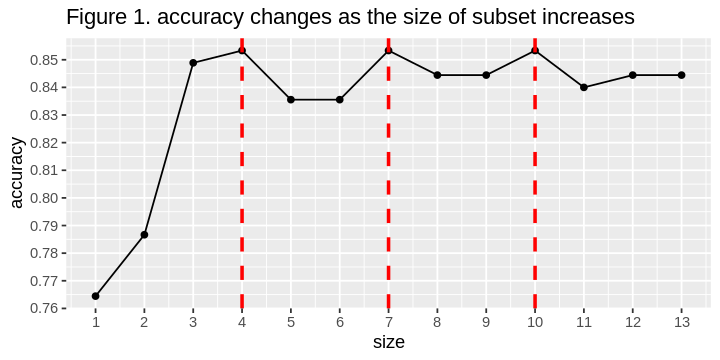

In [27]:
options(repr.plot.width = 6, repr.plot.height = 3)
# plot accuracies against size
forward_selection_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) + 
    geom_line() + 
    geom_point() + 
    geom_vline(xintercept = 4, linetype = "dashed", colour = "red", size = 1) +
    geom_vline(xintercept = 7, linetype = "dashed", colour = "red", size = 1) +
    geom_vline(xintercept = 10, linetype = "dashed", colour = "red", size = 1) +
    scale_x_continuous(breaks = seq(1, 13, by =  1)) + 
    scale_y_continuous(breaks = seq(0,  1, by = .01)) + 
    ggtitle("Figure 1. accuracy changes as the size of subset increases")
forward_selection_plot

According to Figure 1, the subsets containing 4, 7 or 10 predictors have a relatively higher accuracy compared to other subsets. Therefore, we will focus on these 3 subsets of predictors.

In [10]:
# filter the subset that has 4, 7, 10 predictors
filter(accuracies, size == 4 | size == 7 | size == 10)

size,model_string,accuracy
<int>,<chr>,<dbl>
4,heart_disease ~ thal+ca+cp+oldpeak,0.8533333
7,heart_disease ~ thal+ca+cp+oldpeak+sex+restecg+trestbps,0.8533333
10,heart_disease ~ thal+ca+cp+oldpeak+sex+restecg+trestbps+chol+thalach+slope,0.8533333


 <center> Table 4: Accuracies of 3 subsets of predictors.

The models with these 3 subsets of predictors have the same accuracy (85.333%). We will determinine the best model in the next step. 

### Tuning the classifier using cross-validation

In the KNN classification algorithm, the parameter K determines how many neighbours will be given a share in the prediction. Thus, a different K value can significantly affect the predictive power. To achieve the highest accuracy, we need to find the best value of K for each subset of predictors.

In [28]:
# use cross-validation to choose best K values
set.seed(1737)
options(repr.plot.width = 7, repr.plot.height = 5)

k_values <- tibble(neighbors = seq(from = 1, to = 50, by = 3))

hd_vfold <- vfold_cv(hd_train, v = 5, strata = heart_disease)

hd_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

# use cross-validation to choose best K value when we choose size = 4, heart_disease ~ thal+ca+cp+oldpeak
hd_recipe_4 <- recipe(heart_disease ~ thal+ca+cp+oldpeak, data = hd_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

hd_results_4 <- workflow() %>% 
    add_recipe(hd_recipe_4) %>% 
    add_model(hd_knn_spec) %>% 
    tune_grid(resamples = hd_vfold, grid = k_values) %>% 
    collect_metrics()

accuracy_plot_4 <- hd_results_4 %>% 
    filter(.metric == "accuracy") %>% 
    select(neighbors, mean) %>% 
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_line() + 
    geom_point() + 
    labs(x = "neighbors", y = "accuracy estimate") + 
    scale_x_continuous(breaks = seq(1, 100, by =  3)) + 
    scale_y_continuous(breaks = seq(0,  1, by = .01)) +
    geom_vline(xintercept = 13, linetype = "dashed", colour = "red", size = 1) + 
    ggtitle("Figure 2. Plot of estimated accuracy versus the number of neighbors (4-predictor model).") 

# use cross-validation to choose best K value when we choose size = 7, heart_disease ~ thal+ca+cp+oldpeak+sex+restecg+trestbps
hd_recipe_7 <- recipe(heart_disease ~ thal+ca+cp+oldpeak+sex+restecg+trestbps, data = hd_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

hd_results_7 <- workflow() %>% 
    add_recipe(hd_recipe_7) %>% 
    add_model(hd_knn_spec) %>% 
    tune_grid(resamples = hd_vfold, grid = k_values) %>% 
    collect_metrics()

accuracy_plot_7 <- hd_results_7 %>% 
    filter(.metric == "accuracy") %>% 
    select(neighbors, mean) %>% 
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_line() + 
    geom_point() + 
    labs(x = "neighbors", y = "accuracy estimate") + 
    scale_x_continuous(breaks = seq(1, 100, by =  3)) + 
    scale_y_continuous(breaks = seq(0,  1, by = .01)) + 
    geom_vline(xintercept = 10, linetype = "dashed", colour = "red", size = 1) + 
    ggtitle("Figure 3. Plot of estimated accuracy versus the number of neighbors (7-predictor model).") 

# use cross-validation to choose best K value when we choose size = 10, heart_disease ~ thal+ca+cp+oldpeak+sex+restecg+trestbps+chol+thalach+slope
hd_recipe_10 <- recipe(heart_disease ~ thal+ca+cp+oldpeak+sex+restecg+trestbps+chol+thalach+slope, data = hd_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

hd_results_10 <- workflow() %>% 
    add_recipe(hd_recipe_10) %>% 
    add_model(hd_knn_spec) %>% 
    tune_grid(resamples = hd_vfold, grid = k_values) %>% 
    collect_metrics()

accuracy_plot_10 <- hd_results_10 %>% 
    filter(.metric == "accuracy") %>% 
    select(neighbors, mean) %>% 
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_line() + 
    geom_point() + 
    labs(x = "neighbors", y = "accuracy estimate") + 
    scale_x_continuous(breaks = seq(1, 100, by =  3)) + 
    scale_y_continuous(breaks = seq(0,  1, by = .01)) +
    geom_vline(xintercept = 19, linetype = "dashed", colour = "red", size = 1) + 
    ggtitle("Figure 4. Plot of estimated accuracy versus the number of neighbors (10-predictor model).") 

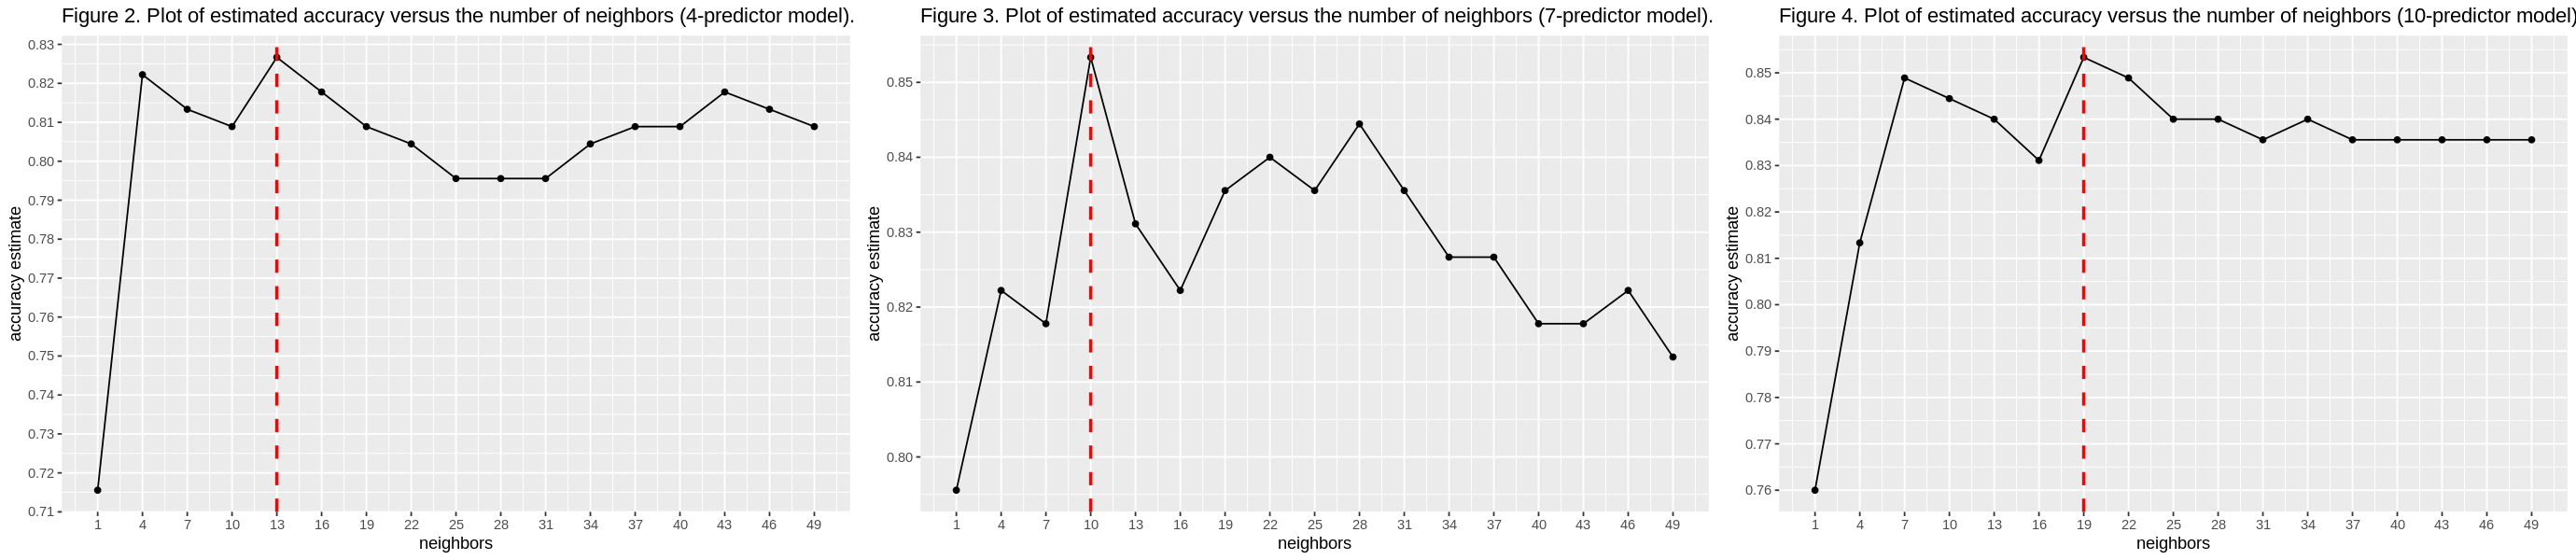

In [29]:
# visualization of accuracies of the cross-validation results 
options(repr.plot.width = 23, repr.plot.height = 5)
grid.arrange(accuracy_plot_4, accuracy_plot_7, accuracy_plot_10, ncol = 3)

According to figures 2-4, the optimal `K` value for the 4, 7, and 10 sized predictor models are `13`, `10` and `19` respectively. As previously discussed, the K values seem reasonable.

Now, we can build the 4 predictors classifier using `K = 13` and `heart_disease ~ thal+ca+cp+oldpeak`

In [13]:
# build classifier using size = 4, heart_disease ~ thal+ca+cp+oldpeak, K = 13 from above results
hd_recipe_4_k13 <- recipe(heart_disease ~ thal+ca+cp+oldpeak, data = hd_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

hd_spec_4_k13 <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")
hd_fit_4_k13 <- workflow() %>% 
    add_recipe(hd_recipe_4_k13) %>% 
    add_model(hd_spec_4_k13) %>% 
    fit(data = hd_train)

# predict test set
hd_predictions_4_k13 <- predict(hd_fit_4_k13, hd_test) %>% 
    bind_cols(hd_test %>% select(heart_disease))

# prediction accuracy
hd_predictions_accuracy_4_k13 <- hd_predictions_4_k13  %>% 
    metrics(truth = heart_disease, estimate = .pred_class) %>% 
    filter(.metric == "accuracy") %>% 
    select(.estimate) %>% 
    pull()

hd_predictions_accuracy_4_k13

[1] 0.8513514

In [14]:
# confusion matrix for 4-predictor model
hd_confusion_4_k13 <- hd_predictions_4_k13 %>% 
    conf_mat(truth = heart_disease, estimate = .pred_class)
hd_confusion_4_k13

          Truth
Prediction absence presence
  absence       38        9
  presence       2       25

Next, we build the 7 predictors classifier using `K = 10` and `heart_disease` ~ `thal + ca + cp + oldpeak + sex + restecg + trestbps`.

In [15]:
# build classifier using size = 7, heart_disease ~ thal+ca+cp+oldpeak, K = 10 from above results
hd_recipe_7_k10 <- recipe(heart_disease ~ thal+ca+cp+oldpeak+sex+restecg+trestbps, data = hd_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

hd_spec_7_k10 <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

hd_fit_7_k10 <- workflow() %>% 
    add_recipe(hd_recipe_7_k10) %>% 
    add_model(hd_spec_7_k10) %>% 
    fit(data = hd_train)

# predict test set
hd_predictions_7_k10 <- predict(hd_fit_7_k10, hd_test) %>% 
    bind_cols(hd_test %>% select(heart_disease))

# prediction accuracy
hd_predictions_accuracy_7_k10 <- hd_predictions_7_k10  %>% 
    metrics(truth = heart_disease, estimate = .pred_class) %>% 
    filter(.metric == "accuracy") %>% 
    select(.estimate) %>% 
    pull()

hd_predictions_accuracy_7_k10

[1] 0.8108108

In [16]:
# confusion matrix for 7-predictor model
hd_confusion_7_k10 <- hd_predictions_7_k10 %>% 
    conf_mat(truth = heart_disease, estimate = .pred_class)
hd_confusion_7_k10

          Truth
Prediction absence presence
  absence       34        8
  presence       6       26

Finally, we build the 10 predictor classifier using `K = 19` and `heart_disease ~ thal + ca + cp + oldpeak + sex + restecg + trestbps + chol + thalach + slope`.

In [17]:
# build classifier using size = 10, heart_disease ~ thal+ca+cp+oldpeak, K = 19 from above results
hd_recipe_10_k19 <- recipe(heart_disease ~ thal+ca+cp+oldpeak+sex+restecg+trestbps+chol+thalach+slope, data = hd_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

hd_spec_10_k19 <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

hd_fit_10_k19 <- workflow() %>% 
    add_recipe(hd_recipe_10_k19) %>% 
    add_model(hd_spec_10_k19) %>% 
    fit(data = hd_train)

# predict test set
hd_predictions_10_k19 <- predict(hd_fit_10_k19, hd_test) %>% 
    bind_cols(hd_test %>% select(heart_disease))

# prediction accuracy
hd_predictions_accuracy_10_k19 <- hd_predictions_10_k19  %>% 
    metrics(truth = heart_disease, estimate = .pred_class) %>% 
    filter(.metric == "accuracy") %>% 
    select(.estimate) %>% 
    pull()

hd_predictions_accuracy_10_k19

[1] 0.8243243

In [18]:
# confusion matrix for 10-predictor model
hd_confusion_10_k19 <- hd_predictions_10_k19 %>% 
    conf_mat(truth = heart_disease, estimate = .pred_class)
hd_confusion_10_k19

          Truth
Prediction absence presence
  absence       36        9
  presence       4       25

The model predicting accuracies on the test set for the `4`, `7` and `10` predictor models are `0.851`, `0.811`, and `0.824` respectively. The model with size `4` had significantly higher accuracy, thus we will pick it as our final model. It should be noted that since the chosen model is only working with 225 observations, it is easy to overfit the data since fewer observations tend to have a lower K parameter. Potential overfitting would lead to the training data exerting too much influence on the model and could result in a simpler predictive model.

In [19]:
summary_table <- tibble(model_accuracy = c(0.851), 
                        false_positive = c(9/34), 
                       false_negative = c(2/40))
summary_table 

model_accuracy,false_positive,false_negative
<dbl>,<dbl>,<dbl>
0.851,0.2647059,0.05


### Visualiation

In [20]:
# get predictions and combine with the test set 
hd_results <- predict(hd_fit_4_k13, hd_test) %>% 
    bind_cols(hd_test %>% select(cp, ca, thal, oldpeak, heart_disease)) 

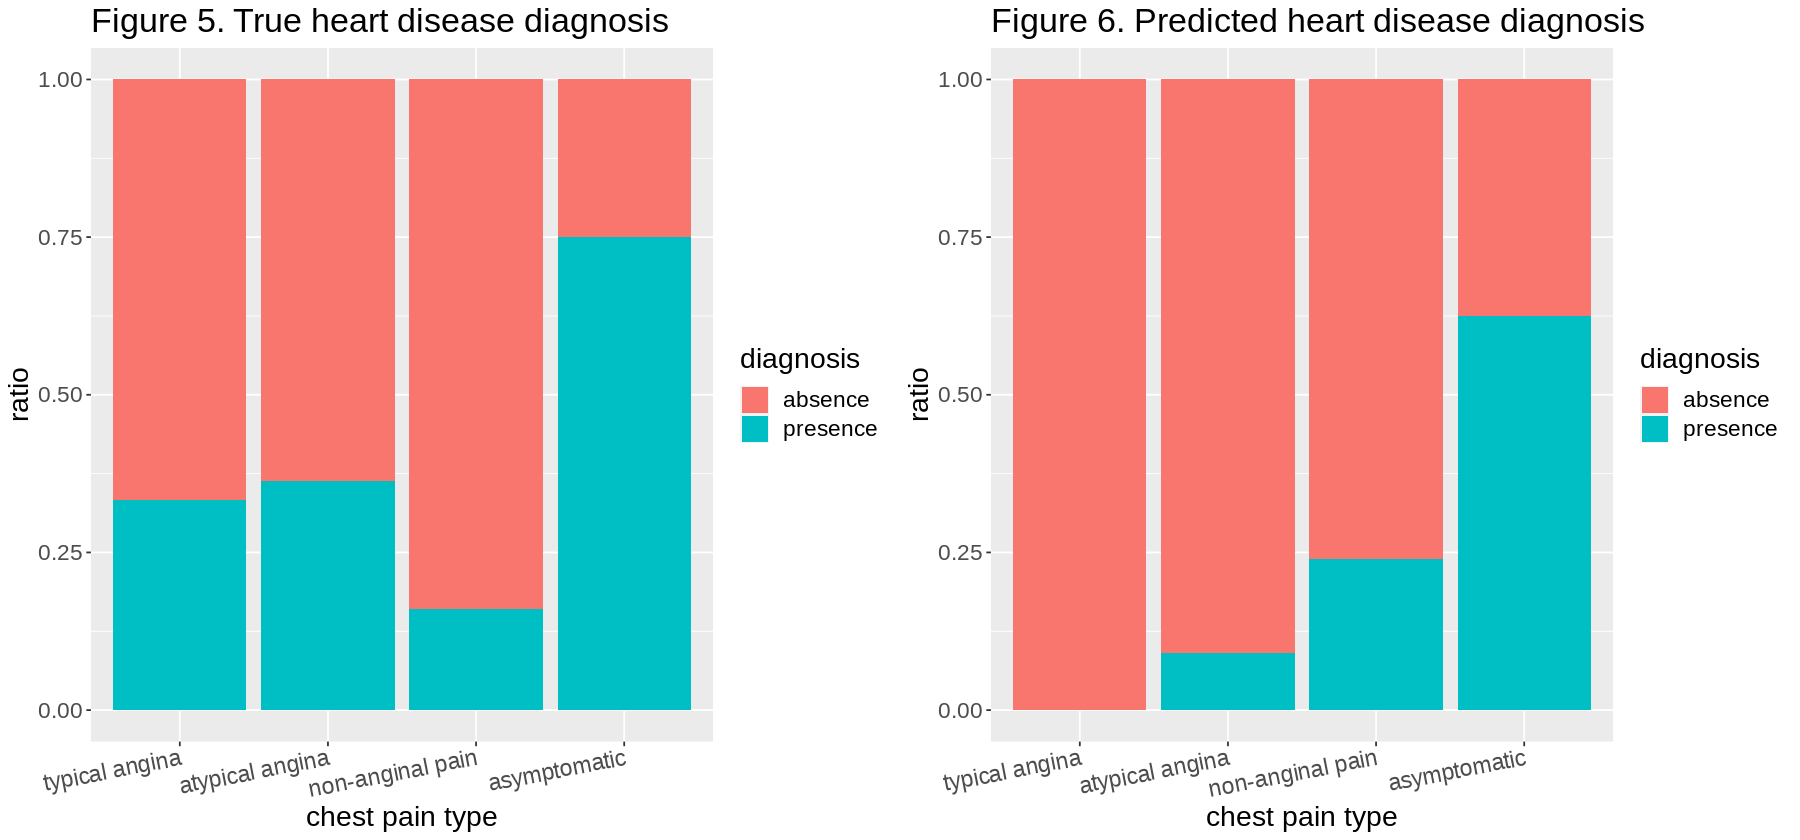

In [30]:
# create visualization for variable cp evaluating the prediction ability in terms of different levels.  
options(repr.plot.width = 15, repr.plot.height = 7)
cp_truth_plot <- hd_results %>% 
    ggplot(aes(x = as_factor(cp), fill = heart_disease)) + 
    geom_bar(position = "fill") + 
    labs(x = "chest pain type", y = "ratio", fill = "diagnosis") + 
    scale_x_discrete(labels = c("typical angina", "atypical angina", "non-anginal pain", "asymptomatic")) + 
    ggtitle("Figure 5. True heart disease diagnosis") + 
    theme(text = element_text(size = 17), axis.text.x = element_text(angle = 11, hjust = 1)) 

cp_pred_plot <- hd_results %>% 
    ggplot(aes(x = as_factor(cp), fill = .pred_class)) + 
    geom_bar(position = "fill") + 
    labs(x = "chest pain type", y = "ratio", fill = "diagnosis") + 
    scale_x_discrete(labels = c("typical angina", "atypical angina", "non-anginal pain", "asymptomatic")) + 
    ggtitle("Figure 6. Predicted heart disease diagnosis") + 
    theme(text = element_text(size = 17), axis.text.x = element_text(angle = 11, hjust = 1)) 

grid.arrange(cp_truth_plot, cp_pred_plot, ncol = 2) 

Figure 5 and figure 6 show the true heart disease diagnosis and predicted diagnosis for patients with four chest pain types, respectively. Our classification model predicted apparently higher ratios for patients with typical angina and atypical angina. While it has a more accurate predictions for patients with non-anginal pain and who are asymptomatic.

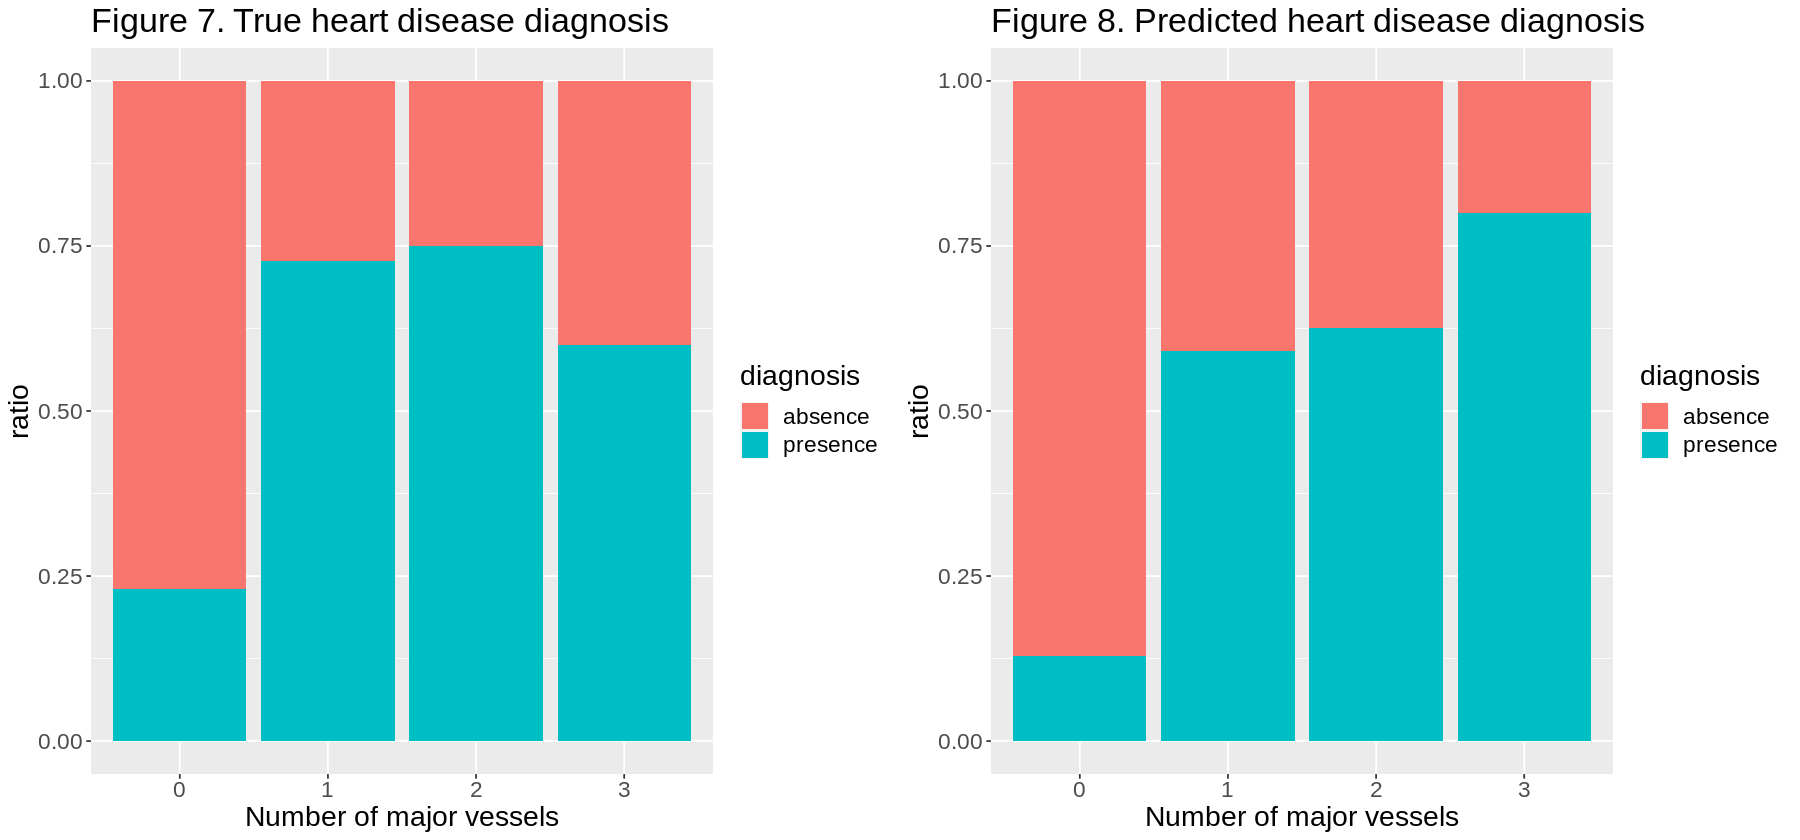

In [31]:
# create visualization for variable ca evaluating the prediction ability in terms of different levels.  
options(repr.plot.width = 15, repr.plot.height = 7)
ca_truth_plot <- hd_results %>% 
    ggplot(aes(x = as_factor(ca), fill = heart_disease)) + 
    geom_bar(position = "fill") + 
    labs(x = "Number of major vessels", y = "ratio", fill = "diagnosis") + 
    scale_x_discrete(labels = c("0", "1", "2", "3")) + 
    ggtitle("Figure 7. True heart disease diagnosis") + 
    theme(text = element_text(size = 17)) 

ca_pred_plot <- hd_results %>% 
    ggplot(aes(x = as_factor(ca), fill = .pred_class)) + 
    geom_bar(position = "fill") + 
    labs(x = "Number of major vessels", y = "ratio", fill = "diagnosis") + 
    scale_x_discrete(labels = c("0", "1", "2", "3")) + 
    ggtitle("Figure 8. Predicted heart disease diagnosis") + 
    theme(text = element_text(size = 17)) 

grid.arrange(ca_truth_plot, ca_pred_plot, ncol = 2) 

Figure 7 and Figure 8 display the true heart disease diagnosis and predicted diagnosis for patients with (0~3) major block vessels. Our classification model predicted apparently higher presence ratios for patients with 3 block major vessels but others are lower.

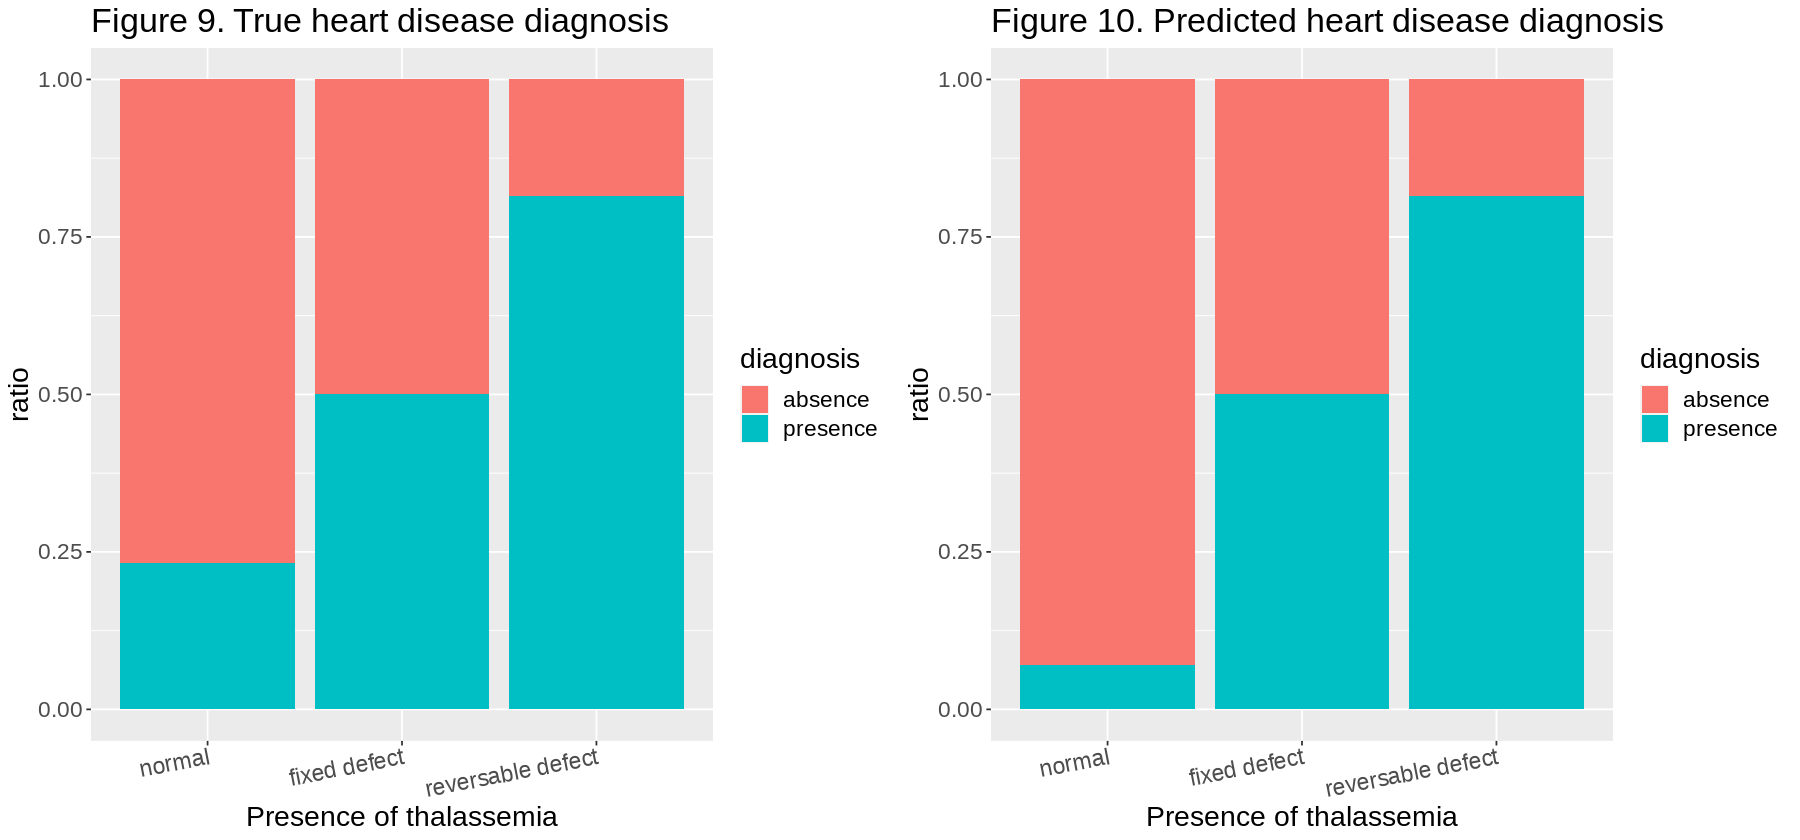

In [32]:
# create visualization for variable thalassemia evaluating the prediction ability in terms of different levels.  
options(repr.plot.width = 15, repr.plot.height = 7)
thal_truth_plot <- hd_results %>% 
    ggplot(aes(x = as_factor(thal), fill = heart_disease)) + 
    geom_bar(position = "fill") + 
    labs(x = "Presence of thalassemia", y = "ratio", fill = "diagnosis") + 
    scale_x_discrete(labels = c("normal", "fixed defect", "reversable defect")) + 
    ggtitle("Figure 9. True heart disease diagnosis") + 
    theme(text = element_text(size = 17), axis.text.x = element_text(angle = 11, hjust = 1)) 

thal_pred_plot <- hd_results %>% 
    ggplot(aes(x = as_factor(thal), fill = .pred_class)) + 
    geom_bar(position = "fill") + 
    labs(x = "Presence of thalassemia", y = "ratio", fill = "diagnosis") + 
    scale_x_discrete(labels = c("normal", "fixed defect", "reversable defect")) + 
    ggtitle("Figure 10. Predicted heart disease diagnosis") + 
    theme(text = element_text(size = 17), axis.text.x = element_text(angle = 11, hjust = 1)) 

grid.arrange(thal_truth_plot, thal_pred_plot, ncol = 2) 

Figure 9 and Figure 10 display the true heart disease diagnosis and predicted diagnosis for the presence of thalassemia for the patients. Our classification model predicted a lower presence ratios for patients with normal thalassemia but others are the same as the true heart disease diagnosis.

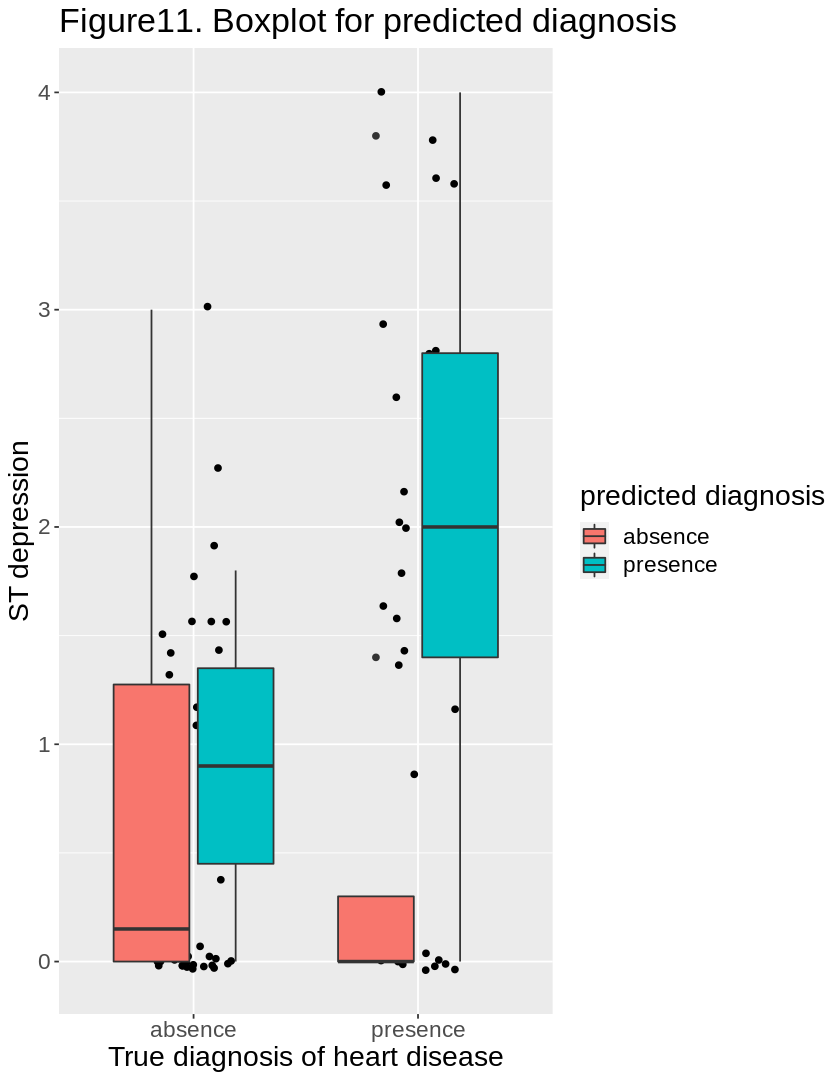

In [150]:
# create visualization for variable oldpeak evaluating the prediction ability in terms of different levels. 
options(repr.plot.width = 7, repr.plot.height = 9)
set.seed(1317) 
oldpeak_plot <- hd_results %>% 
    ggplot(aes(x = heart_disease, y = oldpeak, fill = .pred_class)) + 
    geom_jitter(width = 0.17) + 
    geom_boxplot() + 
    labs(x = "True diagnosis of heart disease", 
         y = "ST depression",
         fill = "predicted diagnosis") + 
    ggtitle("Figure11. Boxplot for predicted diagnosis") + 
    theme(text = element_text(size = 17)) 

oldpeak_plot

By looking at the visualization figures, it is clear that there are still obvious differences between the real data set and those estimated by our model.

# Discussion
As stated above, the model utilizing 4 predictors demonstrated the highest accuracy when running the test set. The descriptions for the 4 predictors can be found in `Table 0`.  Thal, or the presence of thalassemia indicates a deficiency of hemoglobin production caused by the inherited blood disorder and has heart disease as a leading cause for early mortality (Borgna-Pignatti et al., 1998). Similarly, chest pain, the number of major artery vessels blocked by calcium buildup, and ST depression on ECG plots are shown to be linked with heart disease (Cheng et al., 1999; Stanford et al., 1993; Okin et al., 2001). All of which establish the variables' relevance as predictors for the model.

Initially, the study was predicted to find a heart disease classifier that attained optimal accuracy without being computationally demanding. While the final model is not computationally demanding, the highest accuracy achieved after running the test set is 85%. In the context of using this model for diagnosing coronary diseases which can result in death if not treated early, the 15% failure rate is too high to be implemented for actual diagnostic practices. According to the confusion matrix for the chosen model, there were more false negatives (26%) than false positives (5%). The relatively high percentage of false negatives can have severe consequences for field applications.

Considering the invasive and pain-inducing nature of procuring coronary angiogram results (Tang et al., 2007), potential diagnostic applications of the model allow for better patient experiences since most of the attributes used are less medically invasive and potentially more accessible due to less equipment involved to obtain the predictive data. The predictive model also offers diagnostic efficiency, which is crucial in preventing the severe symptoms caused by heart disease (Baidya, 2020).

Since the chosen model can predict heart disease with a high level of accuracy, there is some merit in exploring whether some of the other less medically invasive attributes from the initial 76 attributes could be used to build a model with a similar or higher degree of accuracy. 

# References: 
Datasets are from the following four institutions: 

    Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
    University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
    University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
    V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Almustafa, K. M. (2020). Prediction of heart disease and classifiers’ sensitivity analysis. BMC Bioinformatics, 21(1), 278-278. https://doi.org/10.1186/s12859-020-03626-y

Baidya, A., & Dept. of Computer Science and Engineering Reva University Bangalore, India. (2020). comparative analysis of multiple classifiers for heart disease classification. International Journal of Advanced Research in Computer Science, 11(3), 6-11. https://doi.org/10.26483/ijarcs.v11i3.6523

Borgna-Pignatti, C., Rugolotto, S., Stefano, P., Piga, A., Gregorio, F., Gamberini, M. R., Sabato, V., Melevendi, C., Cappellini, M. D., & Verlato, G. (1998). Survival and Disease Complications in Thalassemia Major. Annals of the New York Academy of Sciences, 850(1), 227–231. https://doi.org/10.1111/j.1749-6632.1998.tb10479.x

Cheng, C., Wong, W., Lai, K., Wong, B. C., Hu, W. H., Hui, W., & Lam, S. (1999). Atypical chest pain patients: A comparison with ischaemic heart disease and control patients. Nordic Journal of Psychiatry, 53(3), 191–195. https://doi.org/10.1080/080394899427197

Okin, P. M., Devereux, R. B., Kors, J. A., Herpen, G., Crow, R. S., Fabsitz, R. R., & Howard, B. V. (2001). Computerized ST Depression Analysis Improves Prediction of All-Cause and Cardiovascular Mortality: The Strong Heart Study. Annals of Noninvasive Electrocardiology, 6(2), 107–116. https://doi.org/10.1111/j.1542-474X.2001.tb00094.x

Stanford, W., Thompson, B. H., & Weiss, R. M. (1993). Coronary artery calcification: Clinical significance and current methods of detection. American Journal of Roentgenology, 161(6), 1139–1146. https://doi.org/10.2214/ajr.161.6.8249716

Tang, P., Liu, H., & Sun, K. (2007). Enhancement of coronary angiogram by estimation of local background. MIPPR 2007: Medical Imaging, Parallel Processing of Images, and Optimization Techniques, 6789, 297–302. https://doi.org/10.1117/12.750703